In [3]:
import numpy as np
import pandas as pd
import datetime as date
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [5]:
df = pd.read_excel('Dados.xlsx')
df.Data = pd.to_datetime(df.Data).dt.date
df.head()

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


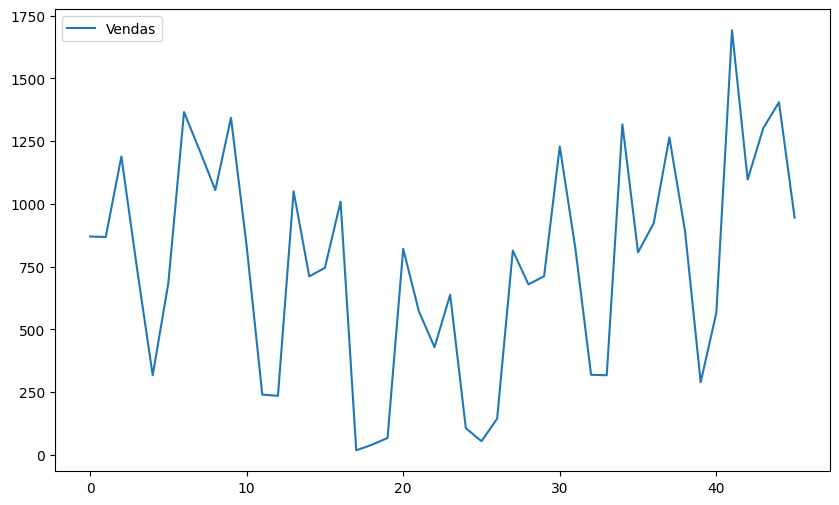

In [252]:
ax = sns.lineplot(data = df)
ax.figure.set_size_inches(10, 6)

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [7]:
#Funcao para plotar graficos na proxima celula
def plotar(y1, y2, y3, label1, label2, label3):
    cor1 = 'blue'
    cor2 = 'red'
    cor3 = 'green'
    plt.figure(figsize = (20, 7))
    plt.plot(y1, color = cor1, label = label1)
    plt.plot(y2, color = cor2, label = label2)
    plt.plot(y3, color = cor3, label = label3)
    plt.legend(fontsize = (16))

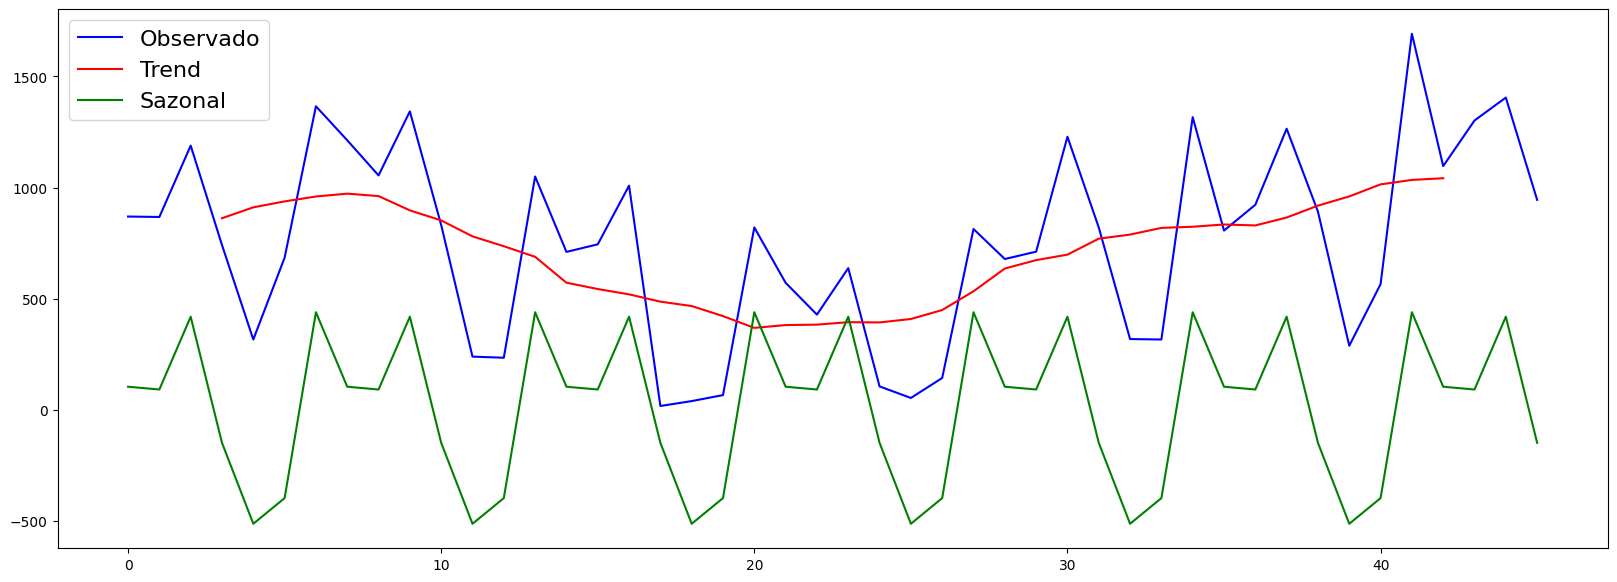

In [8]:
resultados = seasonal_decompose(df.Vendas, period = 7)
plotar(resultados.observed, resultados.trend, resultados.seasonal, "Observado", 'Trend', 'Sazonal')

#Decompondo série temporal para entender como tendência e sazonalidade influenciam o comportamento

In [18]:
#Teste estatistico para verificar estacionariedade da série temporal

from statsmodels.tsa.stattools import adfuller
y = df['Vendas']
p_value = adfuller(y.dropna())[1]
print('p value: %.3f' %p_value)

## p-value superior a 0.05 quer dizer que a hipótese nula (h0) nao pode ser rejeitada, indicando
## que os dados sofrem influencia de tendencia e sazonalidade
## o ideal é que os dados sejam estacionários para que a previsao seja mais próxima da realidade

p value: 0.530


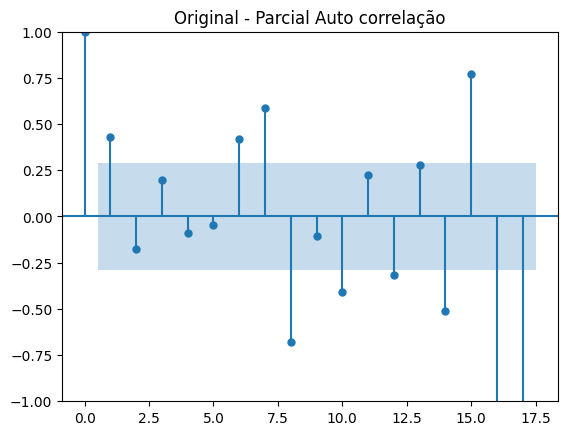

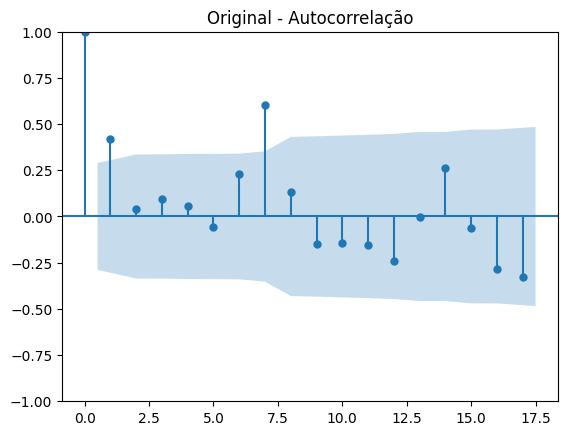

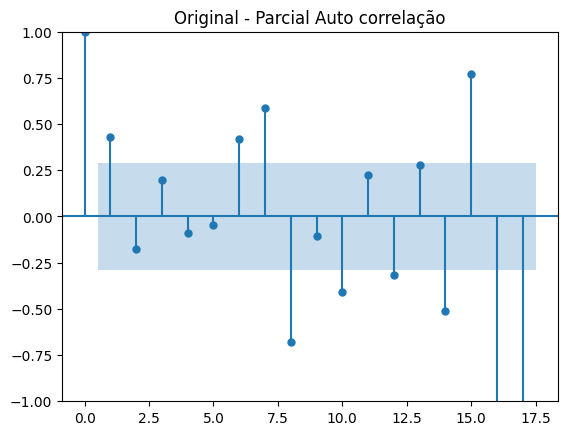

In [26]:
#O modelo utilizado será o SARIMAX
# ele utiliza o o modelo autoregressivo e o Moving Average e leva em conta a sazonalidade dos dados
# Para entender os parâmetros usados é importante entender os niveis de autocorrelacao
# e autocorrelação parcial, que será visto abaixo

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = df['Vendas']
plot_acf(y, title='Original - Autocorrelação')
plot_pacf(y, title='Original - Parcial Auto correlação')

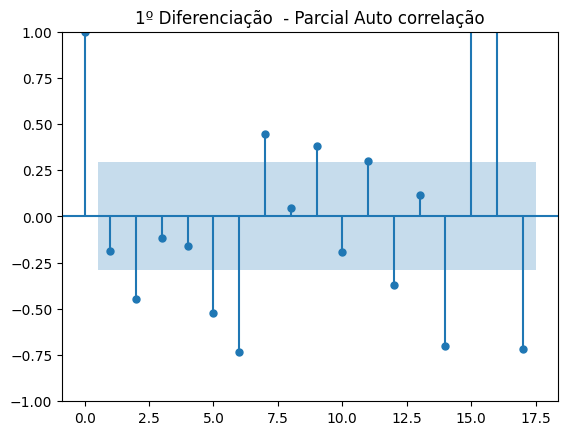

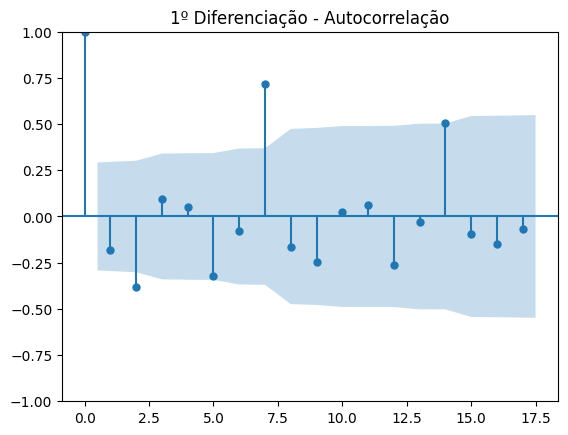

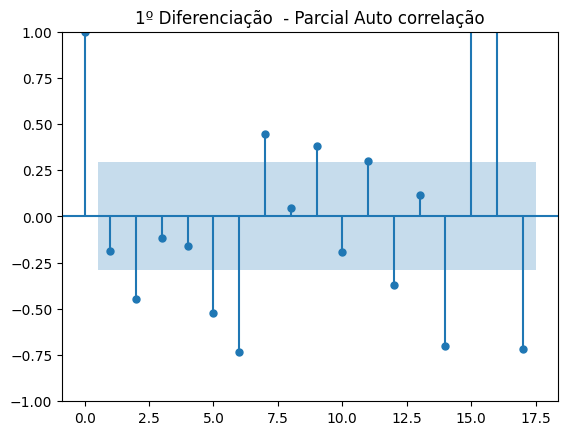

In [28]:
plot_acf(y.diff().dropna(), title='1º Diferenciação - Autocorrelação')
plot_pacf(y.diff().dropna(), title='1º Diferenciação  - Parcial Auto correlação')


In [ ]:
##OBSERVAÇÃO:  Tentei implementar uma técnica que automatiza a procura pelos melhores parâmetros
# utilizando a biblioteca itertools e o auto_arima, com base no AIC ou BIC, no entanto não obtive sucesso. 
# Então os parametros (p, d, q) e (p, d, q, s) foram escolhidos com base no estudo dos parâmetros
# e comportamento dos dados, para ver como melhor se adequariam ao modelo.
# Com estes consegui o melhor resultado. Continuo estudando para melhorar os parametros.

In [24]:
#Separando em treino e teste, fazendo o fit e as previsoes
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

#Utilizando os ultimos 7 dias para testar as previsoes do modelo
train = df['Vendas'].iloc[:-7]
test_y = df['Vendas'].iloc[-7:]
test = df.iloc[-7:]


model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
results = model.fit()

start = len(train)
end = len(train) + len(test) -1

#Previsão para os dados de teste
previsoes = results.predict(start= start, end= end, dynamic=True) 
comparativo = pd.concat([test, previsoes], axis = 1)

#Calculando erro medio absoluto
erro_medio_abs = mean_absolute_error(prev, test_y )


Text(0.5, 1.0, 'Comparativo: Real x Previsão')

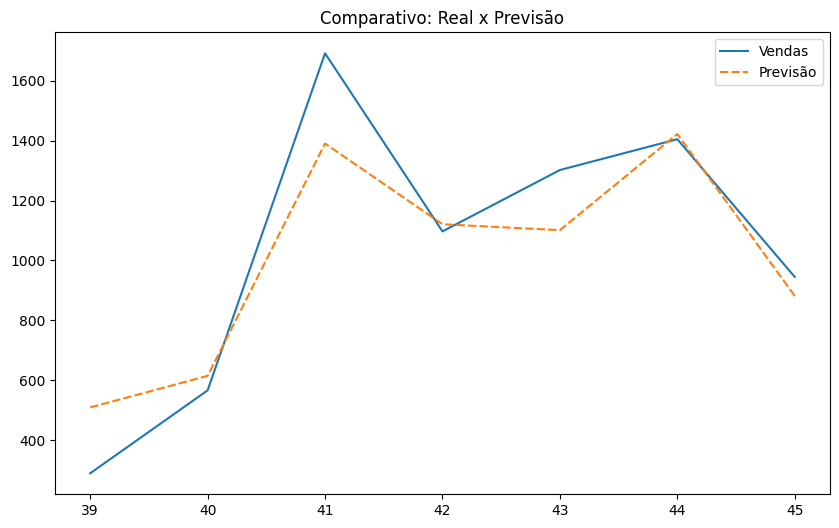

In [29]:
## Comparativo do real e da previsão
comparativo.rename(columns = {'predicted_mean' : 'Previsão'}, inplace = True)
ax = sns.lineplot(data = comparativo)
ax.figure.set_size_inches(10, 6)
ax.set_title('Comparativo: Real x Previsão')

In [38]:
#Prevendo quantidade de vendas nos próximos 5 dias

previsoes = results.predict(start= end+1, end= end + 5) 
previsoes = pd.DataFrame(previsoes)
previsoes.rename(columns = {'predicted_mean' : "Quantidade de Vendas"}, inplace = True)

previsoes
qtd_total_de_vendas = int(previsoes['Quantidade de Vendas'].sum())
previsoes


,Quantidade de Vendas
46,560.022109
47,657.795766
48,1434.911396
49,1165.103229
50,1145.368211


In [32]:
print('Previsão do total de vendas nos próximos 5 dias é de %d ' % qtd_total_de_vendas)
print('Erro Médio Absoluto: %.2f' %erro_medio_abs)

Previsão do total de vendas nos próximos 5 dias é de 4963 
Erro Médio Absoluto: 125.09
